# Random Bayesian Network generation, no tears

This notebook shows how to generate singly- and multi-connected Bayesian Belief Networks (BBNs). The algorithms are taken directly from [here](https://pdfs.semanticscholar.org/5273/2fb57129443592024b0e7e46c2a1ec36639c.pdf). When generating a BBN, you have to generate

* the structure, which is a directed acyclic graph (DAG), and
* the parameters, which are local probability models.

In this notebook, the parameters are assumed to take on the [Dirichlet-Multinomial](https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution) distribution. If you are wondering, a singly-connected BBN is one when, ignoring the directions of the edges in the DAG, there is at most one path between any two nodes. A multi-connected BBN is one that is not singly-connected (it is defined by the negation of a singly-connected BBN). The BBNs generated using this approach gaurantees the distribution of the BBNs are uniformly distributed (look at the paper for proofs, details, and benefits of having this property). 

# Generate the structure

Here, we generate the DAGs of a singly- and multi-connected BBN. Note that when we visualize the DAGs, we do so by converting it to an undirected graph only because the layout algorithm is more aesthetically pleasing.

In [1]:
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt
from networkx.algorithms.dag import is_directed_acyclic_graph
from networkx.algorithms.shortest_paths.generic import shortest_path

np.random.seed(37)

def get_simple_ordered_tree(n):
    """
    Generates a simple-ordered tree. The tree is just a 
    directed acyclic graph of n nodes with the structure
    0 --> 1 --> .... --> n.
    """
    g = nx.DiGraph()
    
    for i in range(n):
        g.add_node(i)
    
    for i in range(n - 1):
        g.add_edges_from([(i, i+1, {})])
    return g

def convert_to_undirected_graph(g):
    """
    Converts a directed acyclic graph (DAG) to an undirected graph.
    We need to convert a DAG to an undirected one to use
    some API calls to operate over the undirected graph. For example,
    in checking for connectedness of a graph, the API has a method
    to check for connectedness of an undirected graph, but not a 
    DAG.
    """
    u = nx.Graph()
    for n in g.nodes:
        u.add_node(n)
    for e in g.edges:
        u.add_edges_from([(e[0], e[1], {})])
    return u

def is_connected(g):
    """
    Checks if a the directed acyclic graph is connected.
    """
    u = convert_to_undirected_graph(g)
    return nx.is_connected(u)

def get_random_node_pair(n):
    """
    Randomly generates a pair of nodes.
    """
    i = np.random.randint(0, n)
    j = i
    while j == i:
        j = np.random.randint(0, n)
    return i, j

def edge_exists(i, j, g):
    """
    Checks if the edge i --> j exists in the graph, g.
    """
    return j in list(g.successors(i))

def del_edge(i, j, g):
    """
    Deletes the edge i --> j in the graph, g. The edge is only
    deleted if this removal does NOT cause the graph to be
    disconnected.
    """
    if g.has_edge(i, j) is True:
        g.remove_edge(i, j)

        if is_connected(g) is False:
            g.add_edges_from([(i, j, {})])
        
def add_edge(i, j, g):
    """
    Adds an edge i --> j to the graph, g. The edge is only
    added if this addition does NOT cause the graph to have
    cycles.
    """
    g.add_edges_from([(i, j, {})])
    if is_directed_acyclic_graph(g) is False:
        g.remove_edge(i, j)
        
def find_predecessor(i, j, g):
    """
    Finds a predecessor, k, in the path between two nodes, i and j,
    in the graph, g. We assume g is connected, and there is a 
    path between i and j (ignoring the direction of the edges).
    We want to find a k, that is a parent of j, that is in
    the path between i and j. In some cases, we may not find
    such a k.
    """
    parents = list(g.predecessors(j))
    u = convert_to_undirected_graph(g)
    for pa in parents:
        try:
            path = shortest_path(u, pa, i)
            return pa
        except:
            pass
    return None
        
def generate_multi_connected_structure(n, max_iter=10):
    """
    Generates a multi-connected directed acyclic graph.
    """
    g = get_simple_ordered_tree(n)
    for it in range(max_iter):
        i, j = get_random_node_pair(n)
        if g.has_edge(i, j) is True:
            del_edge(i, j, g)
        else:
            add_edge(i, j, g)
    return g
    
def generate_singly_structure(n, max_iter=10):
    """
    Generates a singly-connected directed acyclic graph.
    """
    g = get_simple_ordered_tree(n)
    
    counter = 0
    for it in range(max_iter):
        i, j = get_random_node_pair(n)
        if g.has_edge(i, j) is True or g.has_edge(j, i) is True:
            pass
        else:
            p = np.random.random()
            k = find_predecessor(i, j, g)
            if k is not None:
                g.remove_edge(k, j)
                if p < 0.5:
                    g.add_edges_from([(j, i, {})])
                else:
                    g.add_edges_from([(i, j, {})])
                
                if is_connected(g) is False:
                    g.add_edges_from([(k, j, {})])
                
                    if p < 0.5:
                        g.remove_edge(j, i)
                    else:
                        g.remove_edge(i, j)
    return g

## Generate DAG for singly-connected BBN

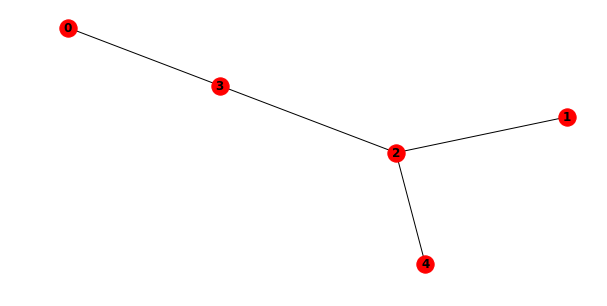

In [2]:
s = generate_singly_structure(5, 1000)
plt.figure(figsize=(10, 5))
plt.subplot(111)
nx.draw(convert_to_undirected_graph(s), with_labels=True, font_weight='bold')

## Generate DAG for multi-connected BBN

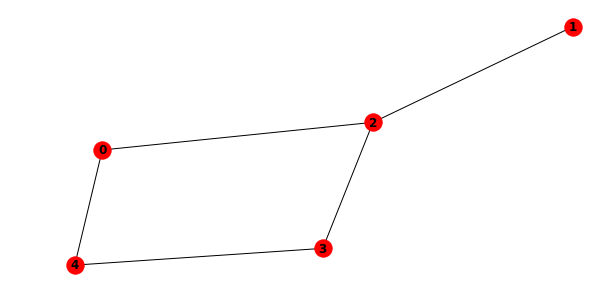

In [3]:
m = generate_multi_connected_structure(5, 10)
plt.figure(figsize=(10, 5))
plt.subplot(111)
nx.draw(convert_to_undirected_graph(m), with_labels=True, font_weight='bold')

# Generate the parameters

Here, we generate parameters for the BBNs. 

In [4]:
from scipy.stats import dirichlet, multinomial

def generate_num_values(n, max_values=2):
    """
    For each node, i, in the nodes, n, determine the number of values
    the node (or equivalently, variable) has. Every node/variable in a
    Bayesian Network should have 2 or more values. This generates
    the number of values each variable will have. Each number will be
    sampled uniformly.
    """
    return np.array([max(np.random.randint(0, max_values) + 1, 2) for _ in range(n)])

def generate_alphas(n, max_alpha=10):
    """
    Generate random number for the alpha's (the hyperparameters).
    Each number will be in the range [1, max_alpha]. Each number will
    be sampled uniformly.
    """
    return [np.random.randint(1, max_alpha + 1) for i in range(n)]

def sample_dirichlet(n, max_alpha=10):
    """
    Samples from the Dirichlet distribution to a produce
    a probability vector of length n. The sum of each probability
    in the probability vector should sum to 1.
    """
    return np.array(dirichlet.rvs(generate_alphas(n, max_alpha))[0])

def get_num_parent_instantiations(parents, num_values):
    num_pa_instantiations = 1
    for pa in parents:
        num_pa_values = num_values[pa]
        num_pa_instantiations *= num_pa_values
    return num_pa_instantiations

def generate_dirichlet_parameters(i, parents, num_values, max_alpha=10):
    """
    Randomly and uniformly generate parameters for a node i. A matrix
    of parameters will be returned. The matrix will represent the 
    condtional probability table of the node i. The matrix will have
    the dimensions m (rows) by n (columns), m x n, where m is the
    product of the domain sizes of the parents, and n is the domain
    size of the node. The domain size is just the number of values
    that a node (variable) has, which should always be greater than
    or equal to 2.
    """
    num_pa_instantiations = get_num_parent_instantiations(parents, num_values)
    
    n = num_values[i]
    cpt = []
    for pa_instantiation in range(num_pa_instantiations):
        probs = sample_dirichlet(n, max_alpha)
        cpt.append(probs)
    return np.array(cpt)

def generate_parameters(g, max_values=2, max_alpha=10):
    """
    Generates parameters for each node in the graph, g.
    A dictionary indexed by the node's id will give its
    (sampled) parameters and its parents. 
    """
    num_nodes = len(list(g.nodes))
    num_values = generate_num_values(num_nodes, max_values)
    g_params = {}
    for i in g.nodes:
        parents = list(g.predecessors(i))
        params = generate_dirichlet_parameters(i, parents, num_values, max_alpha)
        g_params[i] = {
            'parents': parents,
            'params': params,
            'shape': [get_num_parent_instantiations(parents, num_values), num_values[i]]
        }
    return g_params

## Generate parameters for singly-connected BBN

In [5]:
s_params = generate_parameters(s)
print(s_params)

{0: {'params': array([[0.71181474, 0.28818526]]), 'shape': [1, 2], 'parents': []}, 1: {'params': array([[0.86794515, 0.13205485]]), 'shape': [1, 2], 'parents': []}, 2: {'params': array([[0.30951571, 0.69048429],
       [0.62682516, 0.37317484],
       [0.67460639, 0.32539361],
       [0.69045561, 0.30954439]]), 'shape': [4, 2], 'parents': [1, 4]}, 3: {'params': array([[0.13664899, 0.86335101],
       [0.67610286, 0.32389714],
       [0.64495344, 0.35504656],
       [0.01785642, 0.98214358]]), 'shape': [4, 2], 'parents': [0, 2]}, 4: {'params': array([[0.52939964, 0.47060036]]), 'shape': [1, 2], 'parents': []}}


## Generate parameters for muti-connected BBN

In [6]:
m_params = generate_parameters(m)
print(m_params)

{0: {'params': array([[0.70820717, 0.29179283]]), 'shape': [1, 2], 'parents': []}, 1: {'params': array([[0.42431414, 0.57568586]]), 'shape': [1, 2], 'parents': []}, 2: {'params': array([[0.48808113, 0.51191887],
       [0.3211454 , 0.6788546 ],
       [0.78121849, 0.21878151],
       [0.14532112, 0.85467888],
       [0.59857619, 0.40142381],
       [0.86211542, 0.13788458],
       [0.14583872, 0.85416128],
       [0.44173526, 0.55826474]]), 'shape': [8, 2], 'parents': [0, 1, 3]}, 3: {'params': array([[0.41767369, 0.58232631]]), 'shape': [1, 2], 'parents': []}, 4: {'params': array([[0.20613309, 0.79386691],
       [0.43029624, 0.56970376],
       [0.4609832 , 0.5390168 ],
       [0.46319254, 0.53680746]]), 'shape': [4, 2], 'parents': [0, 3]}}


# Persist (save) the Bayesian Belief Network

Here, we show how to save the BBN (the DAG and parameters). Note that we save it to a JSON file format. There are simply too many formats for BBNs, but the JSON format here has all the information you need to convert it to any other format.

In [7]:
def to_json(g, params, pretty=False):
    j = {}
    
    j['nodes'] = list(g.nodes)
    j['edges'] = [{'pa': e[0], 'ch': e[1]} for e in g.edges]
    j['parameters'] = [{'node': k, 'params': list(v['params'].flatten()), 'shape': v['shape'] } for k, v in params.items()]
    return json.dumps(j, indent=2, sort_keys=False) if pretty is True else json.dumps(j)

## Persist singly-connected BBN

In [8]:
s_json = to_json(s, s_params)
print(s_json)
with open('singly-connected.json', 'w') as fhandle:
    fhandle.write(to_json(s, s_params, pretty=True))

{"nodes": [0, 1, 2, 3, 4], "edges": [{"ch": 3, "pa": 0}, {"ch": 2, "pa": 1}, {"ch": 3, "pa": 2}, {"ch": 2, "pa": 4}], "parameters": [{"node": 0, "shape": [1, 2], "params": [0.711814740302191, 0.28818525969780895]}, {"node": 1, "shape": [1, 2], "params": [0.8679451522459679, 0.13205484775403206]}, {"node": 2, "shape": [4, 2], "params": [0.30951571279178186, 0.6904842872082181, 0.6268251609478351, 0.37317483905216486, 0.6746063859505065, 0.3253936140494935, 0.6904556123600698, 0.3095443876399302]}, {"node": 3, "shape": [4, 2], "params": [0.1366489944259987, 0.8633510055740012, 0.6761028569976281, 0.32389714300237193, 0.6449534409078249, 0.3550465590921751, 0.01785642355198514, 0.982143576448015]}, {"node": 4, "shape": [1, 2], "params": [0.5293996424146508, 0.47060035758534935]}]}


# Persist multi-connected BBN

In [9]:
m_json = to_json(m, m_params)
print(m_json)
with open('multi-connected.json', 'w') as fhandle:
    fhandle.write(to_json(m, m_params, pretty=True))

{"nodes": [0, 1, 2, 3, 4], "edges": [{"ch": 2, "pa": 0}, {"ch": 4, "pa": 0}, {"ch": 2, "pa": 1}, {"ch": 2, "pa": 3}, {"ch": 4, "pa": 3}], "parameters": [{"node": 0, "shape": [1, 2], "params": [0.708207170258224, 0.29179282974177606]}, {"node": 1, "shape": [1, 2], "params": [0.4243141440938187, 0.5756858559061814]}, {"node": 2, "shape": [8, 2], "params": [0.48808112571102985, 0.5119188742889702, 0.3211453986705949, 0.6788546013294051, 0.7812184851465944, 0.21878151485340552, 0.14532112326194915, 0.8546788767380509, 0.5985761943499486, 0.4014238056500515, 0.8621154224909061, 0.1378845775090939, 0.14583871638409399, 0.8541612836159059, 0.44173525886699105, 0.5582647411330088]}, {"node": 3, "shape": [1, 2], "params": [0.41767369456638126, 0.5823263054336187]}, {"node": 4, "shape": [4, 2], "params": [0.20613308839993905, 0.7938669116000611, 0.43029624441485004, 0.56970375558515, 0.4609831964438165, 0.5390168035561835, 0.4631925375186775, 0.5368074624813227]}]}


# All-in-one (AIO) example

Here's a simple AIO example of generating a singly-connected BBN and its corresponding JSON.

In [10]:
g = generate_singly_structure(5, 1000)
p = generate_parameters(g)
j = to_json(g, p)

# References

* [Random generation of Bayesian Networks](https://pdfs.semanticscholar.org/5273/2fb57129443592024b0e7e46c2a1ec36639c.pdf)
* [SciPy Dirichlet](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.dirichlet.html)
* [SciPy Multinomial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html)
* [The JSON Validator](https://jsonlint.com/)

# Take a Look!

Take a look at [Dr. Amos Tversky](https://en.wikipedia.org/wiki/Amos_Tversky)!